# Tutorial: solving electronic structure problem

### Overview

This is overview architecture of this demo

![electronic_structure_problem](images/electronic_structure_problem.png)

### Implementation

Let's see how we can implement this.
For full implementation [see here](./source_files/electronic_structure_problem.py).

```python
from quantum_serverless import run_qiskit_remote, get


@run_qiskit_remote()
def ground_state_solve(
    molecule: Molecule,
    initial_point: Union[List[float], np.ndarray],
    options: Optional[Options] = None,
    service: Optional[Union[QiskitRuntimeService, Dict[str, Any]]] = None,
):
    driver = PySCFDriver.from_molecule(molecule=molecule, ...)
    es_problem = ElectronicStructureProblem(driver, ...)
    ansatz = ...
    operator = qubit_converter.convert(es_problem.second_q_ops(), ...)
    optimizer = COBYLA(maxiter=500)
    ...
    
    with Session(service=service) as session:
        estimator = Estimator(session=session, options=options)

        vqe = EstimatorVQE(
            estimator=estimator,
            circuit=ansatz,
            optimizer=optimizer,
            init_point=initial_point,
        )

        vqe_result = vqe.compute_minimum_eigenvalue(operator)
       
    return vqe_result.optimal_value


def electronic_structure_problem(
    molecules: List[Molecule],
    initial_points: Optional[List[List[float]]] = None,
    service: Optional[QiskitRuntimeService] = None,
    backends: Optional[List[IBMQBackend]] = None,
):
    ...
    function_references = [
        hardware_efficient_ansatz(
            molecule=molecule,
            initial_point=initial_point,
            service=service,
        )
        for molecule, initial_point in zip(molecules, initial_points)
    ]

    return get(function_references)
```

### Execution

In [1]:
import os
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_nature.drivers import Molecule
from qiskit.algorithms.optimizers import SPSA

from quantum_serverless import QuantumServerless, Program

In [2]:
import sys
sys.path.append("./source_files/")

from source_files.electronic_structure_problem import electronic_structure_problem

In [3]:
# default initialization
serverless = QuantumServerless()

In [4]:
USE_RUNTIME = False

service = None
backends = None
if USE_RUNTIME:
    service = QiskitRuntimeService()
    names = ["ibmq_qasm_simulator", "ibmq_qasm_simulator", "ibmq_qasm_simulator"]
    backends = [service.backend(name) for name in names]

In [5]:
%%capture

with serverless:
    energies = electronic_structure_problem(
        molecules=[
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.0])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 1.5])], charge=0, multiplicity=1),
            Molecule(geometry=[("H", [0.0, 0.0, 0.0]), ("Li", [0.0, 0.0, 2.0])], charge=0, multiplicity=1),
        ],
        initial_points=[
            [0.1, 0.1, 0.1, 0.1],
            [0.01, 0.01, 0.01, 0.01],
            [0.001, 0.001, 0.001, 0.001],
        ],
        service=service,
        backends=backends,
        optimization_level = 1,
        resilience_level = 1,
        shots=4000,
        optimizer=SPSA(),
        use_local_simulator=not USE_RUNTIME
    )

In [6]:
print("Energies: ", [e[0] for e in energies])
print("Shifts: ", [e[1] for e in energies])
print("Energy + shift: ", [e[0] + e[1] for e in energies])

Energies:  [-0.984816780849255, -1.0949470017011422, -0.7100079453821824]
Shifts:  [-6.6097847711303315, -6.781951626949086, -6.87041467842551]
Energy + shift:  [-7.594601551979586, -7.876898628650228, -7.580422623807692]


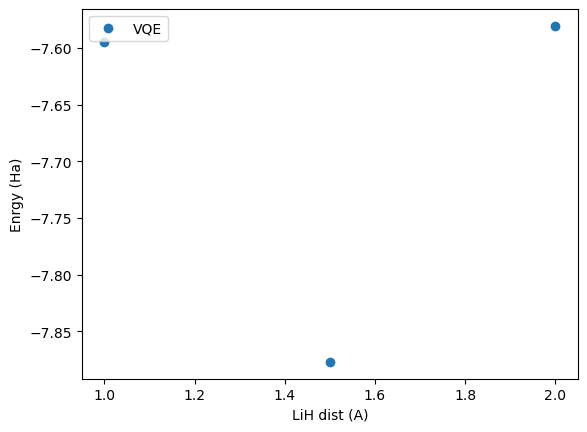

In [7]:
dist = [1.0,1.5,2.0]
plt.plot(dist, [e[0] + e[1] for e in energies], 'o', label = 'VQE')
plt.xlabel('LiH dist (A)')
plt.ylabel('Enrgy (Ha)')
plt.legend()
plt.show()